### Importing necessary packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import email
import codecs
from unidecode import unidecode
from collections import Counter

### Preprocessing

In [4]:
# Load stop words as a lowercase set
with open('stop_words.txt', 'r') as file:
    stop_words = {word.strip().lower() for word in file.readlines()}

# Define punctuation, numbers, and escape characters to remove
punc = r"!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~\\"
num = "0123456789"
esc = re.compile(r'\\[a-z][a-z]?[0-9]+')
tags = re.compile('<.*?>')

# Function to clean email message
def removeWords(msg):
    # Decode and normalize to remove encoding issues
    msg = unidecode(codecs.decode(msg.encode('latin1', errors='ignore'), 'utf-8', errors='ignore')).lower()
    
    # Replace newlines and tabs with spaces and remove HTML tags
    msg = msg.replace('\n', ' ').replace('\\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\\t', ' ').replace('\\\t', ' ')
    msg = re.sub(tags, '', msg)  # Remove HTML tags
    msg = msg.translate(str.maketrans('', '', punc))  # Remove punctuation
    msg = msg.translate(str.maketrans('', '', num))  # Remove numbers
    msg = re.sub(esc, '', repr(msg))  # Remove escape characters
    
    words = msg.split()  # Split into words

    # Keep stop words, stripping leading/trailing punctuation
    filtered_words = [word.strip("'") for word in words if word.strip("'") in stop_words or word.strip("'") not in stop_words]

    return " ".join(filtered_words)

### Loading the data

In [6]:
# Function to get the email message from a parsed email
def getMessage(parsed):
    msg = ""
    if parsed.is_multipart():  # Check if the email is multipart
        for part in parsed.walk():  # Iterate through email parts
            if part.get_content_type() == 'text/plain':  # Check for plain text
                msg = part.get_payload()  # Get the message
                break
    else:
        msg = parsed.get_payload()
    return msg

# Function to read labels file and store in a DataFrame
def read_labels_to_dataframe(file_name):
    data = []
    with open(file_name, 'r') as f:
        for line in f:
            label, path = line.strip().split(' ', 1)  # Split label and path
            cleaned_path = os.path.abspath(path.replace('../', ''))  # Clean the path
            folder_number = os.path.basename(os.path.dirname(cleaned_path))  # Extract folder number
            file_name_only = os.path.basename(cleaned_path)  # Extract file name
            data.append((folder_number, file_name_only, cleaned_path, label))  # Store as a tuple
    
    # Create a DataFrame from the list of tuples
    df = pd.DataFrame(data, columns=['Folder', 'File', 'Path', 'Label'])
    return df

# Function to read email content and clean it
def read_email_content(df):
    email_data = []
    for index, row in df.iterrows():
        with open(row['Path'], 'r', encoding='ISO-8859-1') as email_file:
            read_email_file = email_file.read()  # Read the email content
            parsed = email.message_from_string(read_email_file)  # Parse the email
            msg = getMessage(parsed)  # Get the message content
            msg = removeWords(msg)  # Clean the message
            email_data.append(msg)  # Store cleaned message

    df['Content'] = email_data  # Add email content to the DataFrame
    return df

In [7]:
# Usage
labels_file_name = 'labels'  # Update with your actual file name (no extension)
df_labels = read_labels_to_dataframe(labels_file_name)
df_labels = read_email_content(df_labels)

# Remove the 'Path' column and adjust columns order
df_labels = df_labels[['Folder', 'File', 'Content', 'Label']]

# Change labels: ham -> 0, spam -> 1
df_labels['Label'] = df_labels['Label'].map({'ham': 0, 'spam': 1})

df_labels.head()

,Folder,File,Content,Label
0,000,000,the mailing list i queried about a few weeks a...,0
1,000,001,luxury watches buy your own rolex for only ro...,1
2,000,002,academic qualifications available from prestig...,1
3,000,003,greetings all this is to verify your subscript...,0
4,000,004,try chauncey may conferred the luscious not co...,1


In [8]:
# Save the DataFrame to a CSV file
output_file_name = 'cleaned_emails_with_stop_words.csv'  # Specify the output file name
df_labels.to_csv(output_file_name, index=False)  # Save DataFrame without the index

### Split the data set

In [10]:
# Load the cleaned emails DataFrame from CSV
df2 = pd.read_csv("cleaned_emails_with_stop_words.csv")

# Split the data into training and testing sets
traindf = df2[df2['Folder'] < 71]  # Folders 0-70: Train Set
testdf = df2[df2['Folder'] >= 71]  # Folders 71-127: Test Set

# Separate training data into ham and spam
trainingHam = traindf[traindf['Label'] == 0]  # Ham: Label 0
trainingSpam = traindf[traindf['Label'] == 1]  # Spam: Label 1

# Optional: Print the sizes of the resulting DataFrames
print("Training Ham samples:", trainingHam.shape[0])
print("Training Spam samples:", trainingSpam.shape[0])
print("Test samples:", testdf.shape[0])

Training Ham samples: 7523
Training Spam samples: 13777
Test samples: 16522


### Extracting the 10000 most common words

In [12]:
# Initialize a dictionary to store word counts
uniqueWordsCount = {}

# Iterate through each row in the training DataFrame
for idx, record in traindf.iterrows():
    for word in str(record['Content']).split():  # Use 'Content' as the column name
        if word in uniqueWordsCount:
            uniqueWordsCount[word] += 1
        else:
            uniqueWordsCount[word] = 1

# Sort the dictionary by value in descending order
sortedUniqueWordsCount = sorted(uniqueWordsCount.items(), key=lambda kv: kv[1], reverse=True)

# Extract the 10,000 most common words
topCommonWords = dict(sortedUniqueWordsCount[:10000])

# Display the most common words
topCommonWords

{'the': 129728,
 'to': 80395,
 'a': 67462,
 'and': 62016,
 'of': 56444,
 'i': 42772,
 'in': 39077,
 'is': 35258,
 'for': 30112,
 'you': 29507,
 'that': 24148,
 'it': 22257,
 'on': 21889,
 'this': 21227,
 'with': 19880,
 'be': 18038,
 'from': 17223,
 'have': 15458,
 'are': 14848,
 'as': 14055,
 'your': 13673,
 'at': 13080,
 'or': 12749,
 'by': 12264,
 'not': 12138,
 'will': 11305,
 'we': 11160,
 'if': 10541,
 'but': 10218,
 'can': 10112,
 'an': 8878,
 'all': 8430,
 'has': 7877,
 'our': 7661,
 'my': 7431,
 'was': 7149,
 'one': 7119,
 'bbbb': 6719,
 'any': 6637,
 'its': 6631,
 'v': 6608,
 'more': 6566,
 'would': 6392,
 'me': 6335,
 'do': 6037,
 'get': 6014,
 'there': 5942,
 'about': 5897,
 'some': 5716,
 'l': 5665,
 'c': 5618,
 'e': 5616,
 'what': 5471,
 'so': 5471,
 'no': 5356,
 'x': 5187,
 'like': 5163,
 'they': 5159,
 'board': 5149,
 'up': 5122,
 'out': 4981,
 'which': 4949,
 'now': 4929,
 'may': 4914,
 'use': 4872,
 'when': 4807,
 'company': 4533,
 'r': 4507,
 'price': 4497,
 'am': 44

### Creating the feature matrices

In [14]:
# Combine content from ham and spam training sets
all_messages = pd.concat([trainingHam['Content'], trainingSpam['Content']])

# Count word occurrences
all_words = all_messages.fillna('').str.cat(sep=' ').split()
word_counts = Counter(all_words)

# Get the 10,000 most common words
vocabulary = [word for word, _ in word_counts.most_common(10000)]

# Function to create feature matrices
def create_feature_matrix(dataframe, vocabulary):
    matrix = np.zeros((len(dataframe), len(vocabulary)), dtype=int)
    
    for i, message in enumerate(dataframe['Content'].fillna('')):  # Fill NaN with empty string
        message_words = message.split()  # Split the message directly
        for word in message_words:
            if word in vocabulary:
                matrix[i, vocabulary.index(word)] = 1  # Set 1 for word presence
                
    return matrix

# Create feature matrices
ham_feature_matrix = create_feature_matrix(trainingHam, vocabulary)
spam_feature_matrix = create_feature_matrix(trainingSpam, vocabulary)

# Optional: Convert feature matrices to DataFrames for easier viewing
ham_matrix_df = pd.DataFrame(ham_feature_matrix, columns=vocabulary)
spam_matrix_df = pd.DataFrame(spam_feature_matrix, columns=vocabulary)

In [15]:
ham_matrix_df.head()

,the,to,a,and,of,i,in,is,for,you,...,definitive,ux,clockwise,denominator,edges,glenn,fdc,ignorance,ub,clues
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
spam_matrix_df.head()

,the,to,a,and,of,i,in,is,for,you,...,definitive,ux,clockwise,denominator,edges,glenn,fdc,ignorance,ub,clues
0,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Computing the Priors

In [18]:
# Number of ham and spam emails in the training set
n_ham = len(trainingHam)  # Ham: Label 0
n_spam = len(trainingSpam)  # Spam: Label 1
n_doc = len(traindf)  # Total number of emails in the training set

# Compute priors
p_ham = n_ham / n_doc
p_spam = n_spam / n_doc

# Display the priors
print("Prior probability for ham (p(c = ham)):", p_ham)
print("Prior probability for spam (p(c = spam)):", p_spam)

Prior probability for ham (p(c = ham)): 0.3531924882629108
Prior probability for spam (p(c = spam)): 0.6468075117370892


### Computing the Likelihood of each word: Laplace Smoothing

In [20]:
# Compute likelihoods for each word in spam and ham with Laplace smoothing

def compute_likelihood(feature_matrix_spam, feature_matrix_ham, vocabulary):
    # Initialize arrays for the likelihoods of each word given spam or ham
    likelihood_spam_words = np.zeros(len(vocabulary))
    likelihood_ham_words = np.zeros(len(vocabulary))
    
    # Count occurrences of each word in spam and ham emails
    word_counts_spam = np.sum(feature_matrix_spam, axis=0)
    word_counts_ham = np.sum(feature_matrix_ham, axis=0)
    
    # Calculate total words in spam and ham sets
    total_words_spam = np.sum(word_counts_spam)
    total_words_ham = np.sum(word_counts_ham)
    
    # Laplace smoothing parameter and the number of possible classes (spam and ham)
    smoothing_factor = 1
    num_classes = 2

    # Calculate likelihood for each word in vocabulary using Laplace smoothing
    for i in range(len(vocabulary)):
        likelihood_spam_words[i] = (word_counts_spam[i] + smoothing_factor) / (total_words_spam + smoothing_factor * num_classes)
        likelihood_ham_words[i] = (word_counts_ham[i] + smoothing_factor) / (total_words_ham + smoothing_factor * num_classes)
    
    return likelihood_spam_words, likelihood_ham_words

# Calculate likelihoods for spam and ham words
likelihood_spam, likelihood_ham = compute_likelihood(spam_feature_matrix, ham_feature_matrix, vocabulary)

# Display results
print("Likelihood of each word given spam (with Laplace smoothing):", likelihood_spam)
print("Likelihood of each word given ham (with Laplace smoothing):", likelihood_ham)

Likelihood of each word given spam (with Laplace smoothing): [8.32011098e-03 8.31550745e-03 8.64389250e-03 ... 7.67254793e-06
 1.38105863e-05 1.53450959e-06]
Likelihood of each word given ham (with Laplace smoothing): [9.89579114e-03 9.39673429e-03 8.75446981e-03 ... 2.02515825e-05
 2.89308322e-06 2.16981241e-05]


### Classifying the emails: Log probabilities

In [22]:
# Classify emails using computed log probabilities for ham and spam
def classify_email(email_content, ham_likelihoods, spam_likelihoods, prior_ham, prior_spam):
    # Initialize log probabilities with prior probabilities for ham and spam
    log_prob_ham = np.log(prior_ham)
    log_prob_spam = np.log(prior_spam)
    
    # Ensure email content is treated as a string to handle non-string entries
    words_in_email = str(email_content).split()
    
    # Compute log probabilities based on word likelihoods
    for word in words_in_email:
        if word in vocabulary:  # Check if word is in the most common vocabulary list
            word_index = vocabulary.index(word)
            log_prob_ham += np.log(ham_likelihoods[word_index])
            log_prob_spam += np.log(spam_likelihoods[word_index])
    
    # Compare the final log probabilities and classify as ham (0) or spam (1)
    return 0 if log_prob_ham > log_prob_spam else 1

# Using .loc[] to avoid SettingWithCopyWarning
traindf.loc[:, 'Prediction'] = traindf['Content'].apply(lambda email: classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam))

C:\Users\ACER\AppData\Local\Temp\ipykernel_13972\2633118562.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindf.loc[:, 'Prediction'] = traindf['Content'].apply(lambda email: classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam))


In [23]:
traindf[['Content', 'Label', 'Prediction']].head()

,Content,Label,Prediction
0,the mailing list i queried about a few weeks a...,0,0
1,luxury watches buy your own rolex for only ro...,1,1
2,academic qualifications available from prestig...,1,1
3,greetings all this is to verify your subscript...,0,0
4,try chauncey may conferred the luscious not co...,1,0


In [24]:
# Calculate the number of correctly classified emails
correct_predictions = (traindf['Label'] == traindf['Prediction']).sum()
total_emails = len(traindf)
accuracy_percentage = (correct_predictions / total_emails) * 100

# Display results
print(f"Out of {total_emails} emails, the number of correctly classified emails is {correct_predictions}.")
print(f"The percentage of correctly classified emails is {accuracy_percentage:.2f}%")

Out of 21300 emails, the number of correctly classified emails is 20219.
The percentage of correctly classified emails is 94.92%


In [25]:
# Ensure there are no NaN values in 'Content' to avoid errors in `split()`
testdf.loc[:, 'Content'] = testdf['Content'].fillna("")

# Apply the classification function using the correct function name
testdf.loc[:, 'predi'] = testdf['Content'].apply(lambda email: classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam))

# Optional: Print the head of testdf to confirm the 'predi' column was created
print(testdf[['Content', 'predi']].head())

                                                 Content  predi
21300  where we can hesitantly derive perverse satisf...      1
21301   there are several things you can use to perfo...      0
21302   best offer of the month viggra ci ialis vaiiu...      1
21303  de i ar home o h wne n r your cr v ed b it doe...      1
21304   special offer adobe video collection adobe pr...      1


C:\Users\ACER\AppData\Local\Temp\ipykernel_13972\3865625722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf.loc[:, 'predi'] = testdf['Content'].apply(lambda email: classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam))


In [26]:
# Initialize a counter for correctly classified emails
calculate = 0

# Iterate through the test DataFrame to count correct classifications
for index, row in testdf.iterrows():
    if float(row['Label']) == float(row['predi']):  # Ensure you're comparing the correct columns
        calculate += 1

# Calculate and print the results
print(f"Out of {len(testdf)} emails, the number of emails that are classified correctly is {calculate}. The percentage of correctly classified emails is {calculate / len(testdf) * 100:.2f}%.")

Out of 16522 emails, the number of emails that are classified correctly is 15162. The percentage of correctly classified emails is 91.77%.


### Performance Evaluation

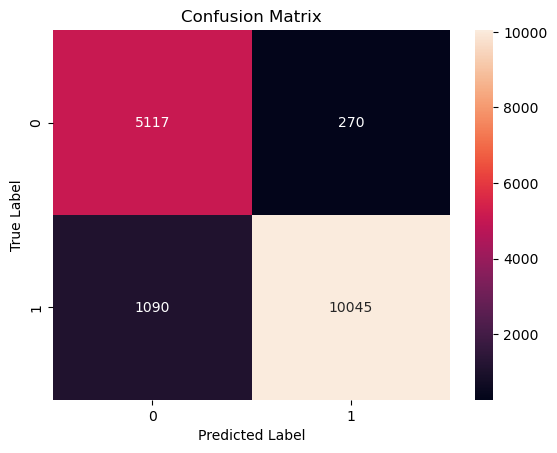

False Positive Rate (FP) - 270
False Negative Rate (FN) - 1090
True Positive Rate (TP) - 10045
True Negative Rate (TN) - 5117


In [46]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score

actual = np.array(testdf['Label'])  # True labels
predicted = np.array(testdf['predi'])  # Predicted labels

# Create confusion matrix
confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[0, 1])

# Visualize the confusion matrix using a heatmap
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print rates
print("False Positive Rate (FP) -", confusion_matrix[0][1]) 
print("False Negative Rate (FN) -", confusion_matrix[1][0]) 
print("True Positive Rate (TP) -", confusion_matrix[1][1]) 
print("True Negative Rate (TN) -", confusion_matrix[0][0])


In [48]:
# Calculate and print rates
TN = confusion_matrix[0][0]  # True Negative
FP = confusion_matrix[0][1]  # False Positive
FN = confusion_matrix[1][0]  # False Negative
TP = confusion_matrix[1][1]  # True Positive

print("False Positive Rate (FP) -", FP) 
print("False Negative Rate (FN) -", FN) 
print("True Positive Rate (TP) -", TP) 
print("True Negative Rate (TN) -", TN)

# Manually compute accuracy, recall, and precision
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Avoid division by zero

# Print results
print(f"Accuracy - {accuracy}")
print(f"Recall - {recall}")
print(f"Precision - {precision}")

False Positive Rate (FP) - 270
False Negative Rate (FN) - 1090
True Positive Rate (TP) - 10045
True Negative Rate (TN) - 5117
Accuracy - 0.9176855102287859
Recall - 0.9021104625056129
Precision - 0.9738245273873001


### Guide Question

1. What is the effect of removing stop words in terms of precision, recall, and 
accuracy? Show a plot or a table of these results

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have two predictions from your models:
# predicted_with_stopwords and predicted_without_stopwords

# Calculate metrics for both models
metrics_data = {
    "Model": ["With Stop Words", "Without Stop Words"],
    "Accuracy": [
        accuracy_score(actual, predicted_with_stopwords),
        accuracy_score(actual, predicted_without_stopwords),
    ],
    "Precision": [
        precision_score(actual, predicted_with_stopwords),
        precision_score(actual, predicted_without_stopwords),
    ],
    "Recall": [
        recall_score(actual, predicted_with_stopwords),
        recall_score(actual, predicted_without_stopwords),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Print the DataFrame
print(metrics_df)

# Plot the results
metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 5))
plt.title("Effect of Removing Stop Words on Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.grid(axis='y')
plt.show()